In [1]:
%cd ..
%ls

/home/nas1_userB/sunghyun/dmkim/M2N2
analyze_compute_cost_2.py*    figures/              README.md*  utils/
analyze_compute_cost_MLP.py*  measure_errorbar.py*  results/    Vis/
analyze_compute_cost.py*      models/               scripts/    wandb/
cfgs/                         notebooks/            test.py*
data/                         outputs/              tmp/
Exp/                          plots/                train.py*


/home/nas1_userB/sunghyun/anaconda3/envs/TSAD/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import warnings; warnings.filterwarnings("ignore");

import torch
from torch import optim
import torch.nn.functional as F

import numpy as np
from utils.tools import setPlotStyle; setPlotStyle()

import matplotlib.pyplot as plt
from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde, entropy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [3]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import *

from easydict import EasyDict as edict
import yaml
import re
import copy

warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [4]:
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-12-12 08:44:10,807] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'SEED': 2023, 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT_normalization_None/SEED_2023', 'log_path': './logs/MLP_SWaT_normalization_None/SEED_2023', 'output_path': './outputs/MLP_SWaT_normalization_None/SEED_2023', 'plot_path': './plots/MLP_SWaT_normalization_None/SEED_2023', 'result_path': './results/MLP_SWaT_normalization_None/SEED_2023', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'save_pr_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128, 'use_sigmoid_output': False, 'use_batchnorm': False, 'use_dropout': 

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'SEED': 2023, 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT_normalization_None/SEED_2023', 'log_path': './logs/MLP_SWaT_normalization_None/SEED_2023', 'output_path': './outputs/MLP_SWaT_normalization_None/SEED_2023', 'plot_path': './plots/MLP_SWaT_normalization_None/SEED_2023', 'result_path': './results/MLP_SWaT_normalization_None/SEED_2023', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'save_pr_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128, 'use_sigmoid_output': False, 'use_batchnorm': False, 'use_dropout': False}, 'home_dir': '.', 'device': device(

[2023-12-12 08:44:16,851] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-12-12 08:44:16,889] Complete.
[2023-12-12 08:44:16,890] Preparing dataloader...
[2023-12-12 08:44:17,134] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-12-12 08:44:17,136] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-12-12 08:44:17,144] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


## Visualize

In [5]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
data_df

FIT101    LIT101   MV101  P101  P102    AIT201  \
 Timestamp                                                                  
 28/12/2015 10:00:00 AM  2.427057  522.8467       2     2     1  262.0161   
 28/12/2015 10:00:01 AM  2.446274  522.8860       2     2     1  262.0161   
 28/12/2015 10:00:02 AM  2.489191  522.8467       2     2     1  262.0161   
 28/12/2015 10:00:03 AM  2.534350  522.9645       2     2     1  262.0161   
 28/12/2015 10:00:04 AM  2.569260  523.4748       2     2     1  262.0161   
...                           ...       ...     ...   ...   ...       ...   
 2/1/2016 2:59:55 PM     2.559972  519.5495       2     2     1  168.0979   
 2/1/2016 2:59:56 PM     2.549082  520.4131       2     2     1  168.0979   
 2/1/2016 2:59:57 PM     2.531467  520.6878       2     2     1  168.0979   
 2/1/2016 2:59:58 PM     2.521218  520.7271       2     2     1  168.0979   
 2/1/2016 2:59:59 PM     2.501681  521.1196       2     2     1  168.0979   

                           AIT202    AIT203    FIT201   MV201  ...  P501  \
 Timestamp                                                     ...         
 28/12/2015 10:00:00 AM  8.396437  328.6337  2.445391       2  ...     2   
 28/12/2015 10:00:01 AM  8.396437  328.6337  2.445391       2  ...     2   
 28/12/2015 10:00:02 AM  8.394514  328.6337  2.442316       2  ...     2   
 28/12/2015 10:00:03 AM  8.394514  328.6337  2.442316       2  ...     2   
 28/12/2015 10:00:04 AM  8.394514  328.6337  2.443085       2  ...     2   
...                           ...       ...       ...     ...  ...   ...   
 2/1/2016 2:59:55 PM     8.638683  301.9226  2.459488       2  ...     2   
 2/1/2016 2:59:56 PM     8.638683  301.9226  2.459488       2  ...     2   
 2/1/2016 2:59:57 PM     8.638683  301.9226  2.460129       2  ...     2   
 2/1/2016 2:59:58 PM     8.638683  301.9226  2.460129       2  ...     2   
 2/1/2016 2:59:59 PM     8.638683  301.9226  2.458206       2  ...     2   

                         P502    PIT501    PIT502    PIT503    FIT601  P601  \
 Timestamp                                                                    
 28/12/2015 10:00:00 AM     1  250.8652  1.649953  189.5988  0.000128     1   
 28/12/2015 10:00:01 AM     1  250.8652  1.649953  189.6789  0.000128     1   
 28/12/2015 10:00:02 AM     1  250.8812  1.649953  189.6789  0.000128     1   
 28/12/2015 10:00:03 AM     1  250.8812  1.649953  189.6148  0.000128     1   
 28/12/2015 10:00:04 AM     1  250.8812  1.649953  189.5027  0.000128     1   
...                       ...       ...       ...       ...       ...   ...   
 2/1/2016 2:59:55 PM        1  251.1535  0.865024  189.0220  0.000000     1   
 2/1/2016 2:59:56 PM        1  251.0734  0.865024  188.9259  0.000000     1   
 2/1/2016 2:59:57 PM        1  251.0734  0.865024  188.9259  0.000000     1   
 2/1/2016 2:59:58 PM        1  251.0734  0.865024  188.9259  0.000000     1   
 2/1/2016 2:59:59 PM        1  251.0734  0.865024  188.9259  0.000000     1   

                         P602  P603  Normal/Attack  
 Timestamp                                          
 28/12/2015 10:00:00 AM     1     1         Normal  
 28/12/2015 10:00:01 AM     1     1         Normal  
 28/12/2015 10:00:02 AM     1     1         Normal  
 28/12/2015 10:00:03 AM     1     1         Normal  
 28/12/2015 10:00:04 AM     1     1         Normal  
...                       ...   ...            ...  
 2/1/2016 2:59:55 PM        1     1         Normal  
 2/1/2016 2:59:56 PM        1     1         Normal  
 2/1/2016 2:59:57 PM        1     1         Normal  
 2/1/2016 2:59:58 PM        1     1         Normal  
 2/1/2016 2:59:59 PM        1     1         Normal  

[449919 rows x 52 columns]

In [6]:
cols = list(data_df.columns)

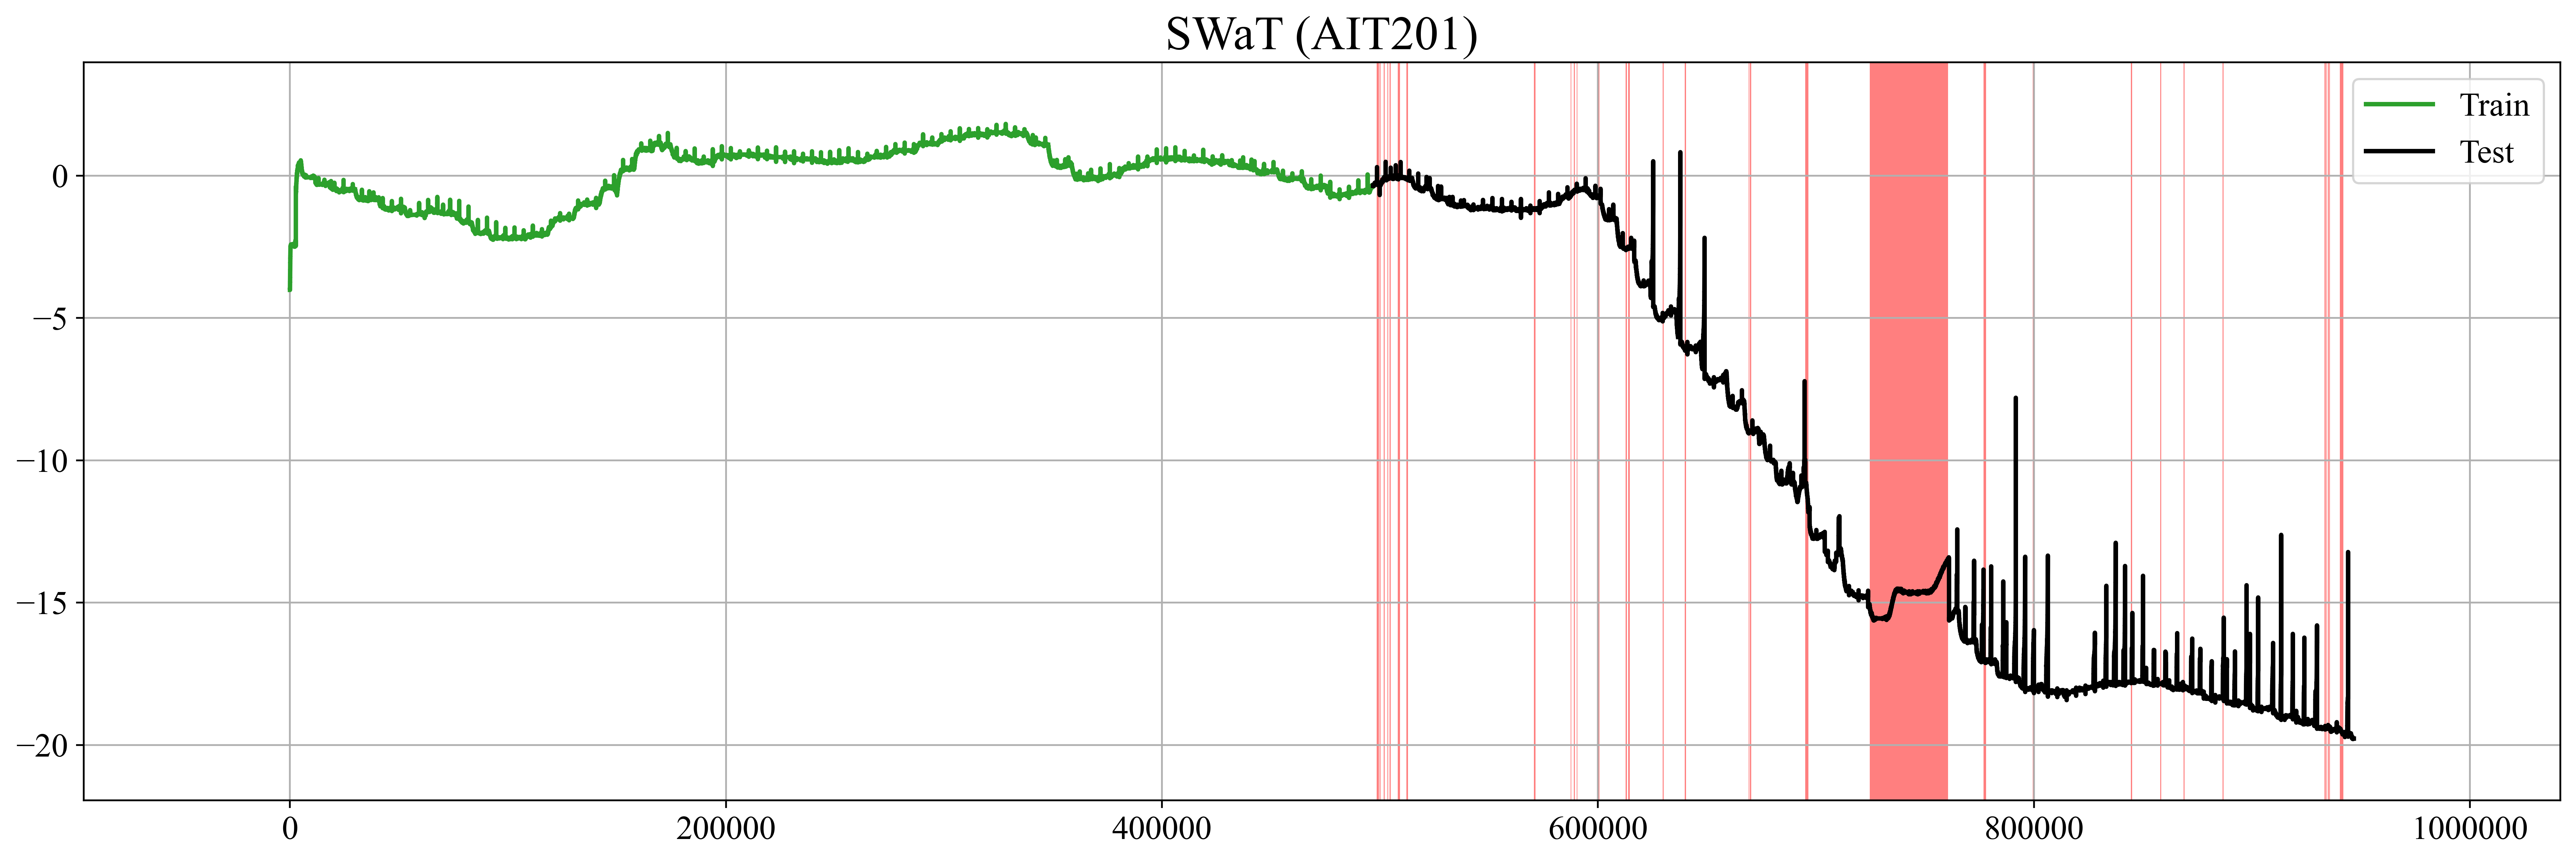

In [7]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)
#plt.title(f"{dataset_name} ({cols[c]})")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")
plt.show()

## TSNE Plot

In [8]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def plot_tsne(train_X, train_y, test_X, test_y, dataset, 
              dim=2,load=True, size=1000, with_anomalies=False, title=None, dpi=100):
    print("="*20)
    
    if with_anomalies:
        base_dir = os.path.join("figures", "TSNE", "wA", dataset)
    else:
        base_dir = os.path.join("figures", "TSNE", dataset)
    os.makedirs(base_dir, exist_ok=True)
    
    if (load==True) and (os.path.exists(os.path.join(base_dir, f"Xtsne_train_{dim}d.npy"))):
        Xtsne_train = np.load(os.path.join(base_dir, f"Xtsne_train_{dim}d.npy"))
        Xtsne_test = np.load(os.path.join(base_dir, f"Xtsne_test_{dim}d.npy"))
        
        if with_anomalies:
            Xtsne_test_anos = np.load(os.path.join(base_dir, f"Xtsne_test_anos_{dim}d.npy"))
        
    else:
        print("finding TSNE...")
        T, C = train_X.shape
        if C == 1:
            return
        
        # filter anomalies
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        mask = (1-test_y).astype(bool)
        if with_anomalies:
            test_X_anos = test_X[~mask]
        test_X = test_X[mask]
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        
        
        # sample
        np.random.seed(2023)
        train_X = train_X[np.random.choice(len(train_X), min(size, len(train_X)))]
        test_X = test_X[np.random.choice(len(test_X), min(size, len(test_X)))]
        test_X_anos = test_X_anos[np.random.choice(len(test_X_anos), min(size//10, len(test_X_anos)))]
        if with_anomalies:
            data = np.concatenate([train_X, test_X, test_X_anos])
        else:
            data = np.concatenate([train_X, test_X])
        print(data.shape)
        
        # kde of TSNE'ed outputs.
        tsne = TSNE(n_components=dim, verbose=1, random_state=2023)
        Xtsne = tsne.fit_transform(data)
        
        if with_anomalies:
            Xtsne_train = Xtsne[:len(train_X)]
            Xtsne_test = Xtsne[len(train_X):len(train_X)+len(test_X)]
            Xtsne_test_anos = Xtsne[len(train_X)+len(test_X):]
        else:
            Xtsne_train = Xtsne[:len(train_X)]
            Xtsne_test = Xtsne[len(train_X):]
        
        print("saving...")
        with open(os.path.join(base_dir, f"Xtsne_train_{dim}d.npy"), "wb") as f:
            np.save(f, Xtsne_train)
        with open(os.path.join(base_dir, f"Xtsne_test_{dim}d.npy"), "wb") as f:
            np.save(f, Xtsne_test)
        
            
        if with_anomalies:
            with open(os.path.join(base_dir, f"Xtsne_test_anos_{dim}d.npy"), "wb") as f:
                np.save(f, Xtsne_test_anos)
            
    
    if dim == 2:
        plt.figure(figsize=(16, 12), dpi=dpi)
        if title:
            plt.title(f"{title}", fontsize=40)
        plt.scatter(Xtsne_train[:,0], Xtsne_train[:,1], color="#F53B6E", s=200, label="Train", marker="o", alpha=0.5)
        plt.scatter(Xtsne_test[:,0], Xtsne_test[:,1], color="#4A87FF",
                    s=200, label="Test (Normals)", marker="*", alpha=0.7)
        if with_anomalies:
            plt.scatter(Xtsne_test_anos[:,0], Xtsne_test_anos[:,1], color="black", 
                        s=240, label="Test (Anomalies)", marker="x", linewidths=1,
                       alpha=0.5
                       )
        
        plt.xticks(fontsize=40)
        plt.yticks(fontsize=40)
        plt.savefig(f"./figures/main_figure/{dataset}_tsne.pdf", dpi=dpi, bbox_inches = "tight")
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(f"3d TSNE plot of {dataset}")
        ax.scatter(Xtsne_train[:,0], Xtsne_train[:,1], Xtsne_train[:,2], color="C0", s=1, label="TSNE of Train")
        ax.scatter(Xtsne_test[:,0], Xtsne_test[:,1], Xtsne_test[:,2], color="black", s=1, label="TSNE of Test")
        plt.show()

## Try smaller dataset

train: (3682, 55), test: (2856, 55), #anos: 20, ratio: 0.0070028011204481795


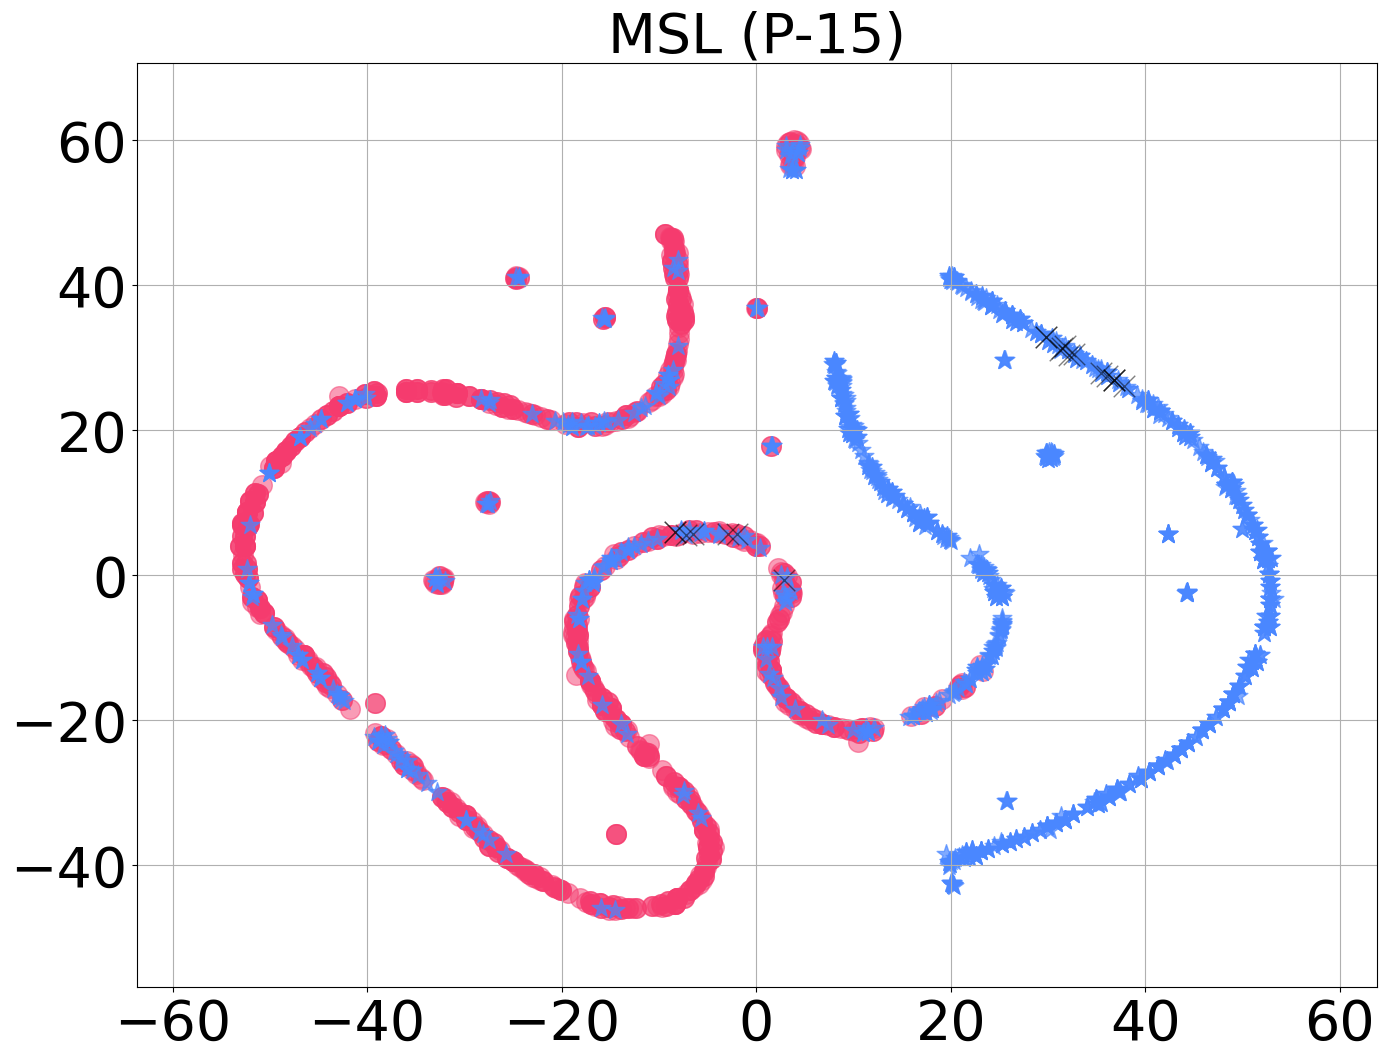

In [10]:
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "MSL_P-15", 2, True, 1000, True, "MSL (P-15)")

## TSNE for ALL Dataset

train: (496800, 51), test: (449919, 51), #anos: 54584, ratio: 0.12131961530853332


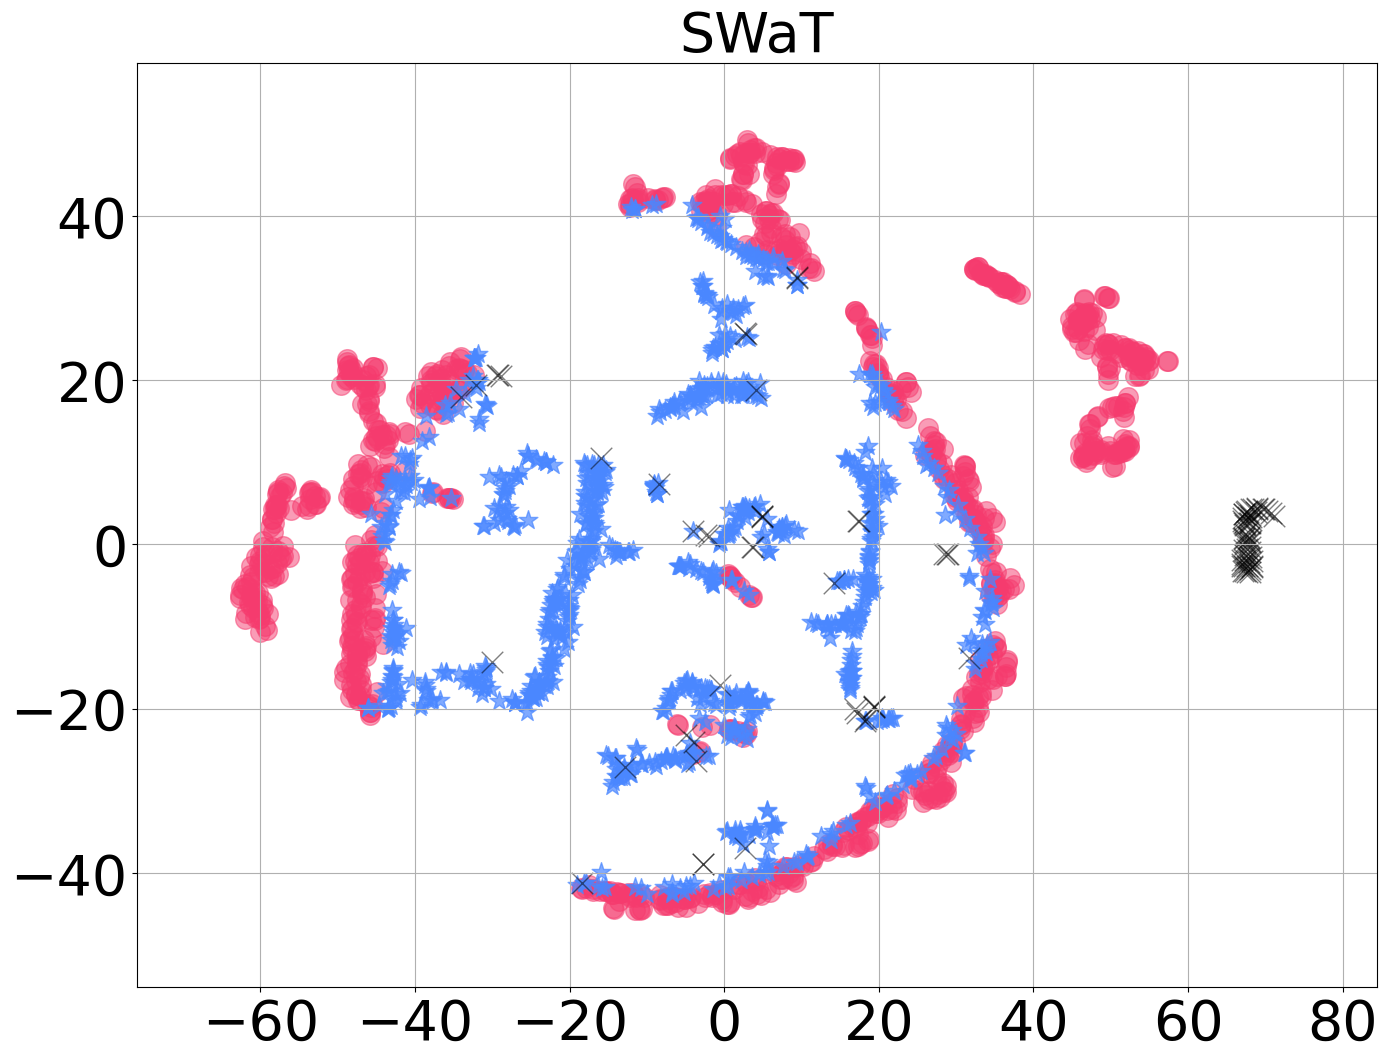

train: (784571, 123), test: (172803, 123), #anos: 9977, ratio: 0.0577362661527867


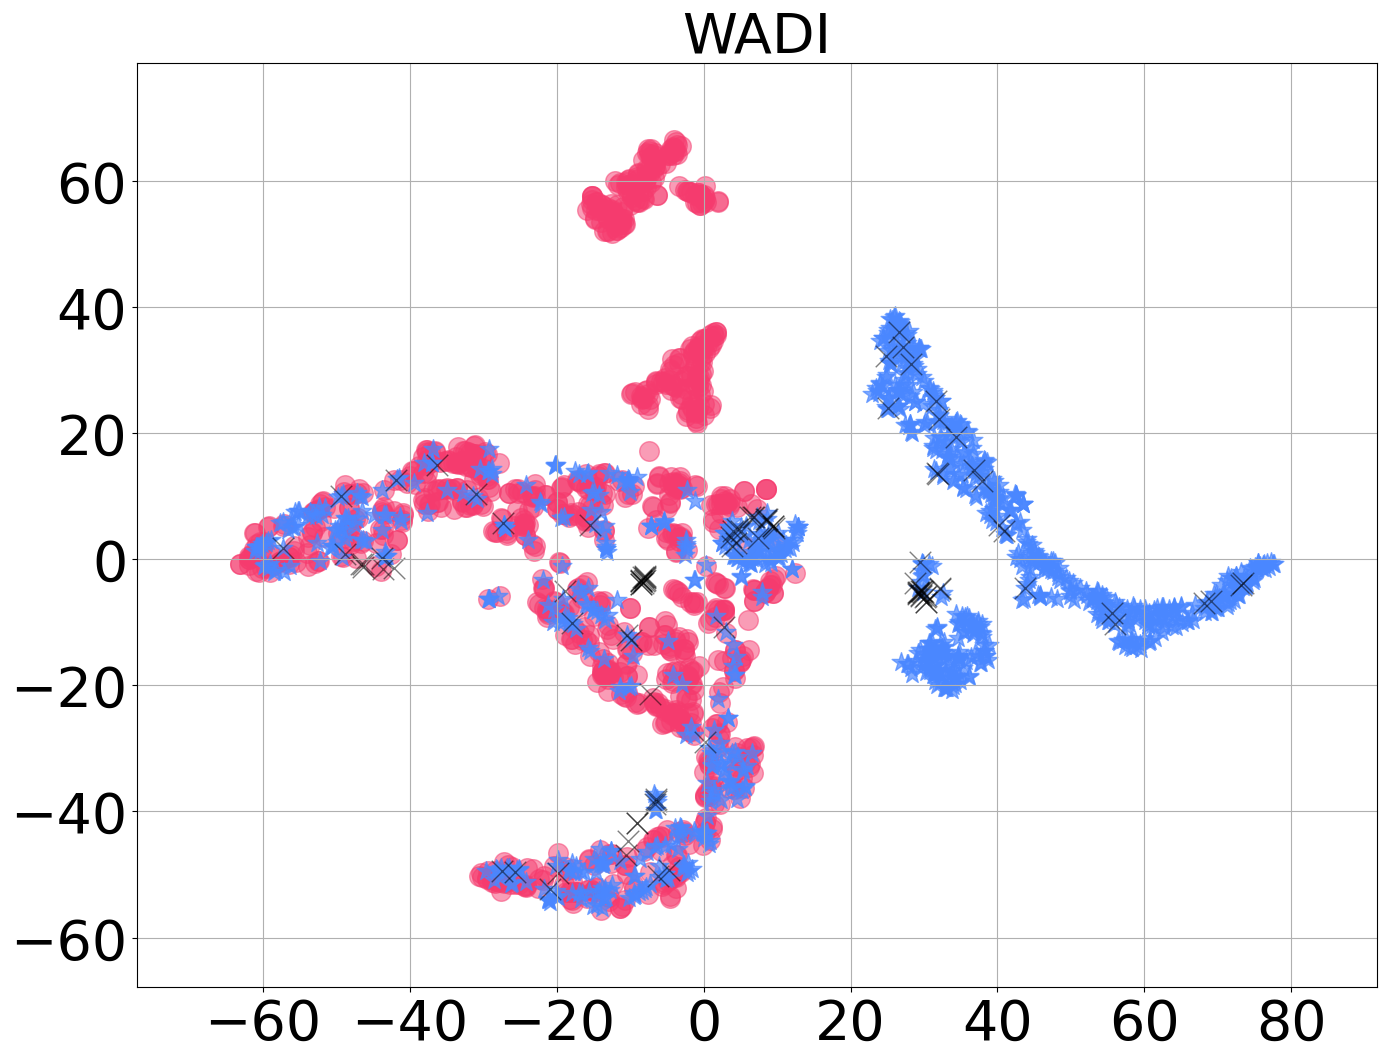

train: (23706, 38), test: (23707, 38), #anos: 720, ratio: 0.030370776563884084


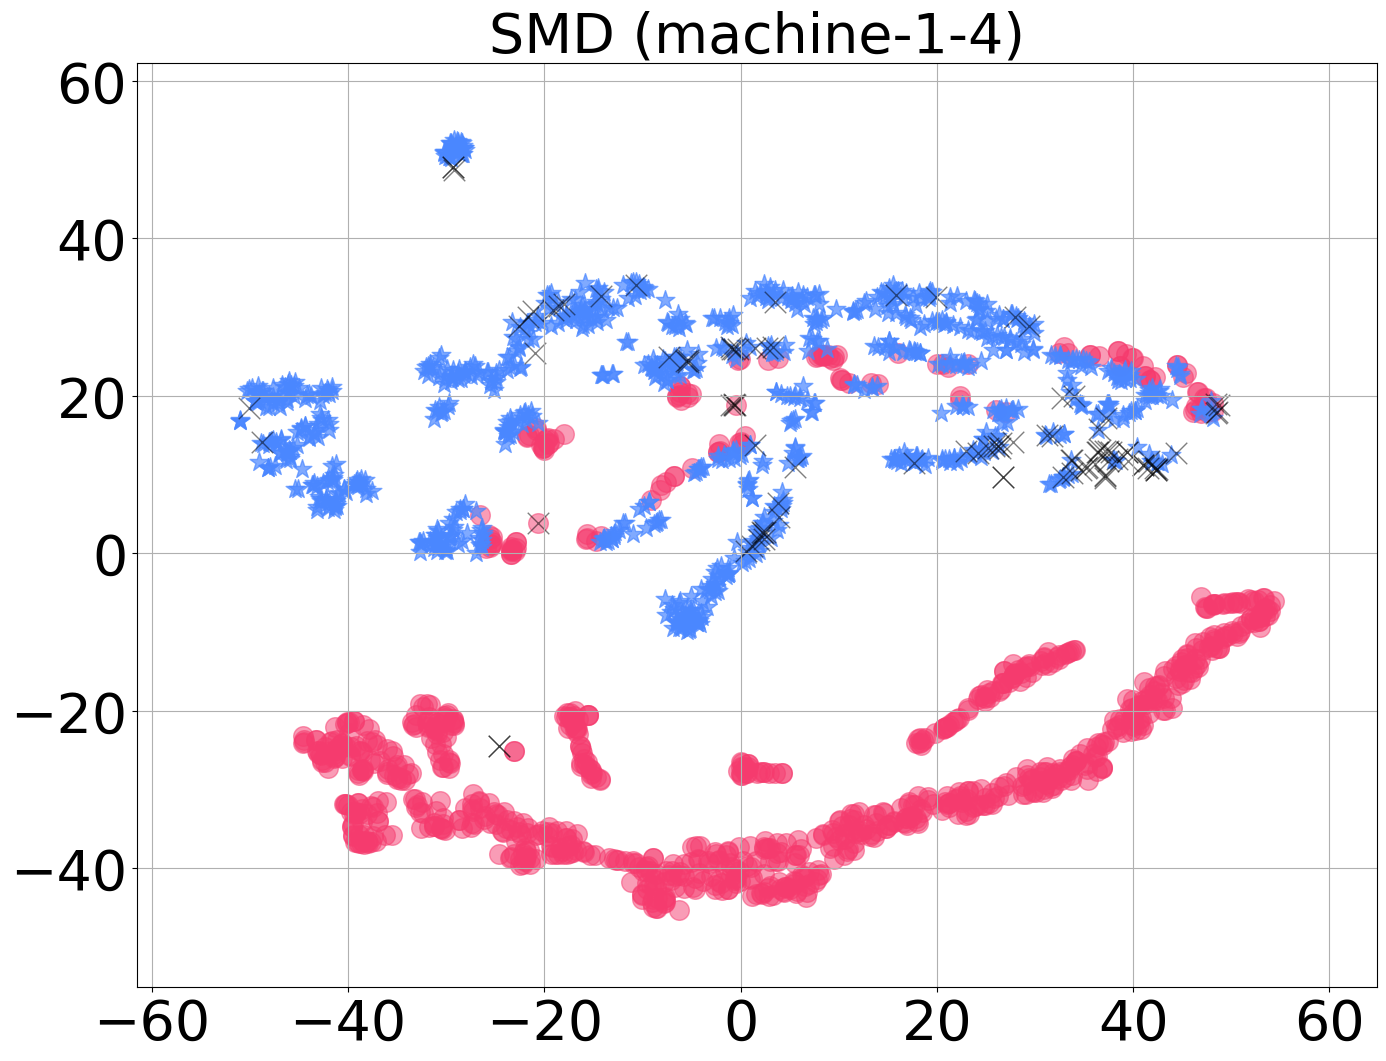

train: (23693, 38), test: (23694, 38), #anos: 1170, ratio: 0.049379589769561916
finding TSNE...
(23693, 38) (23693,) (23694, 38) (23694,)
(23693, 38) (23693,) (22524, 38) (23694,)
(210, 38)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 210 samples in 0.000s...
[t-SNE] Computed neighbors for 210 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 210 / 210
[t-SNE] Mean sigma: 0.202765
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.859791
[t-SNE] KL divergence after 1000 iterations: 0.260846
saving...


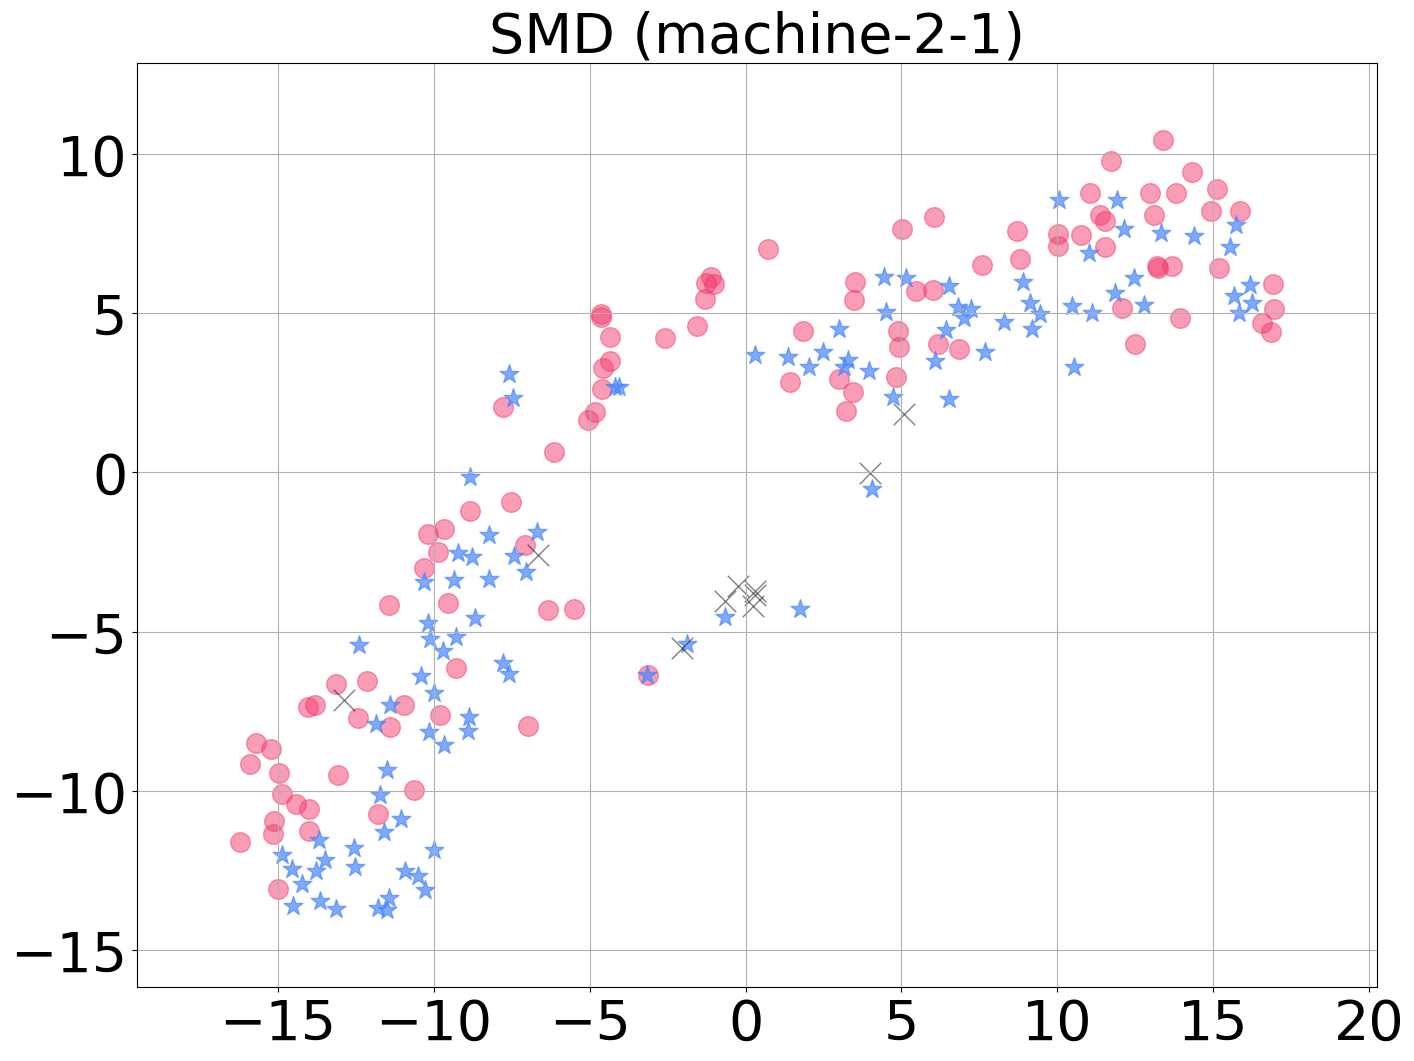

train: (3682, 55), test: (2856, 55), #anos: 20, ratio: 0.0070028011204481795


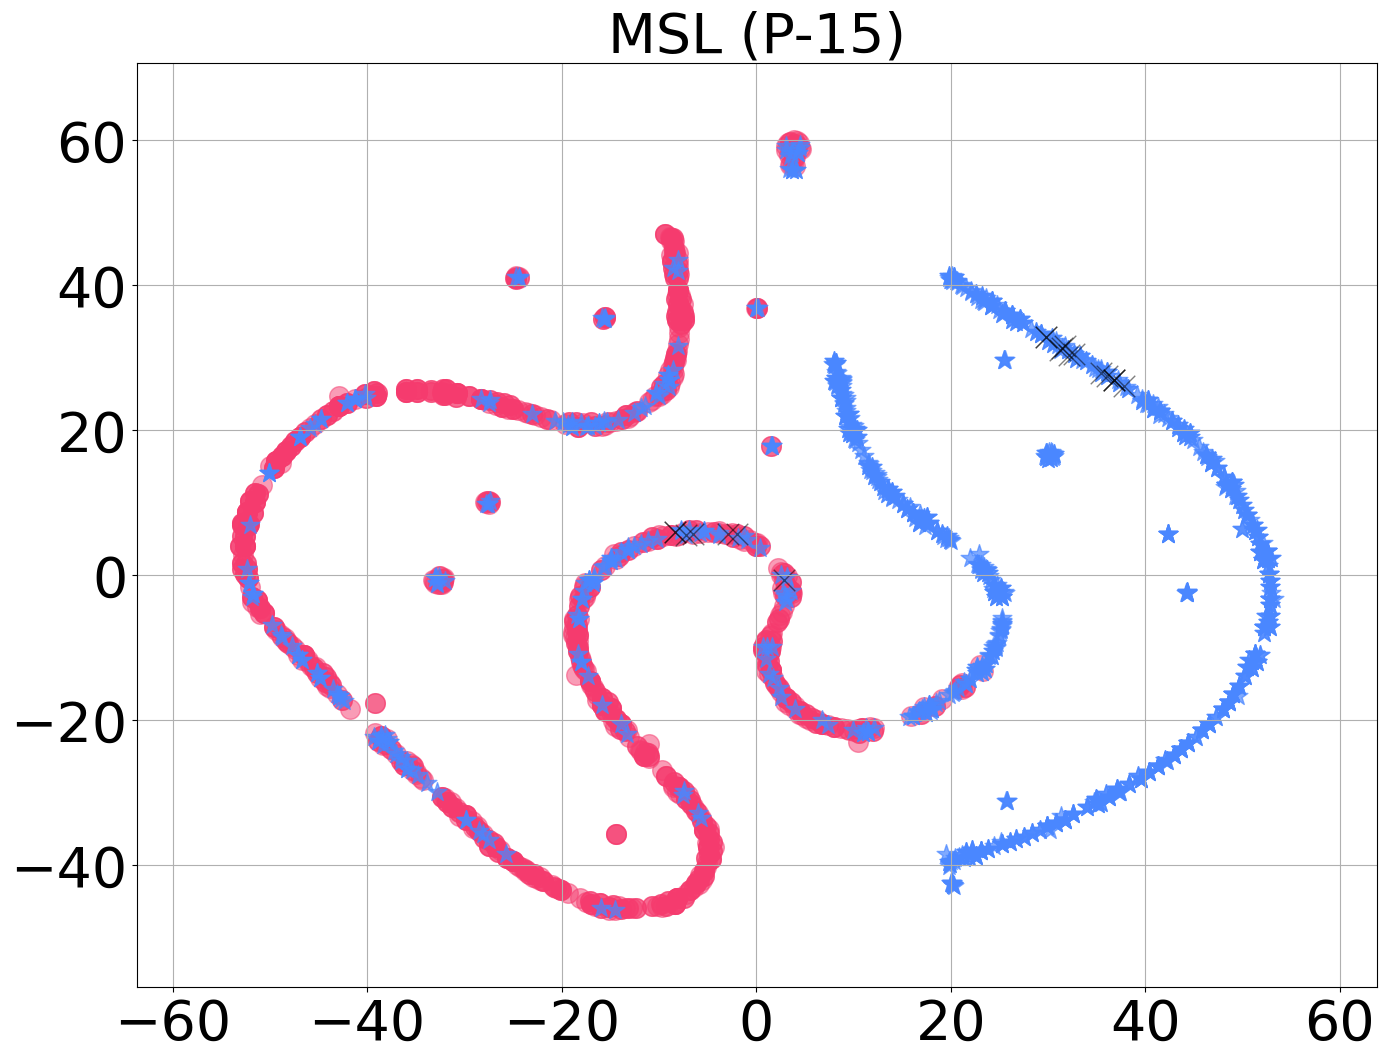

train: (2876, 25), test: (8579, 25), #anos: 182, ratio: 0.02121459377549831
finding TSNE...
(2876, 25) (2876,) (8579, 25) (8579,)
(2876, 25) (2876,) (8397, 25) (8579,)
(210, 25)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 210 samples in 0.000s...
[t-SNE] Computed neighbors for 210 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 210 / 210
[t-SNE] Mean sigma: 0.002026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.868233
[t-SNE] KL divergence after 1000 iterations: -2.599613
saving...


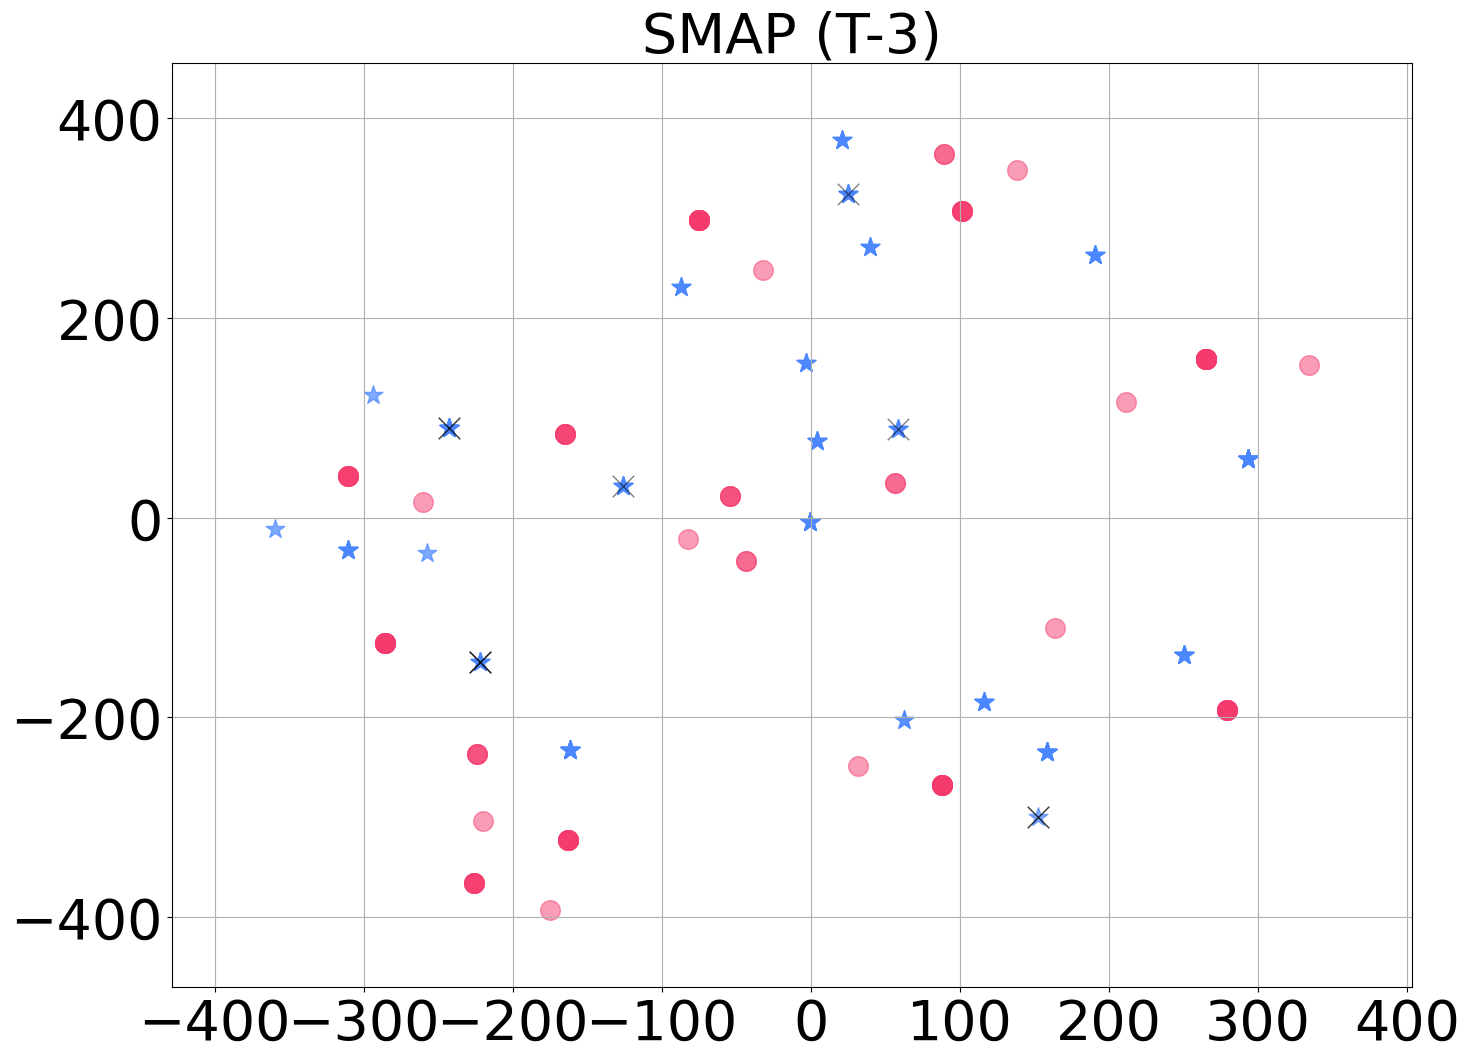

train: (142403, 29), test: (142404, 29), #anos: 223, ratio: 0.0015659672481110082


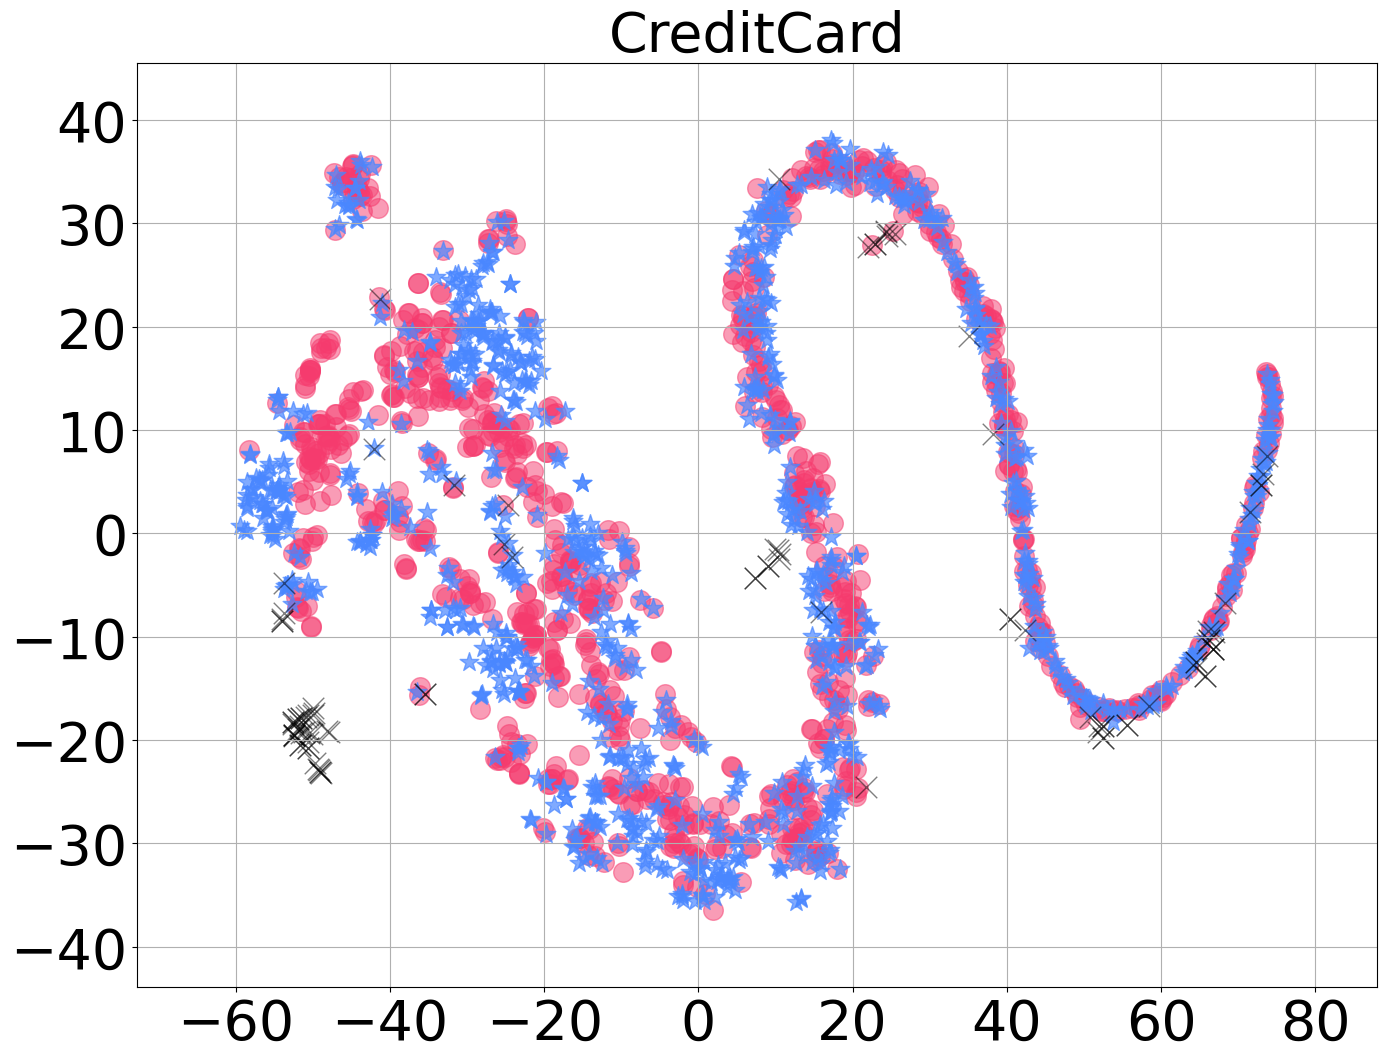

train: (400, 1), test: (1022, 1), #anos: 33, ratio: 0.03228962818003914
finding TSNE...
train: (400, 1), test: (1027, 1), #anos: 5, ratio: 0.004868549172346641
finding TSNE...


In [12]:
datasets = ["SWaT", "WADI", "PSM", "CreditCard", "MSL_P-15", "SMD_machine-1-4", "yahoo_20"]
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "SWaT", 2, True, 100, True, "SWaT")
#plot_tsne(train_X, train_y, test_X, test_y, "SWaT", 3, True, 1000)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "WADI", 2, True, 100, True, "WADI")
#plot_tsne(train_X, train_y, test_X, test_y, "WADI", 3, True, 1000)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "SMD_machine-1-4", 2, True, 100, True, "SMD (machine-1-4)")
#plot_tsne(train_X, train_y, test_X, test_y, "SMD_machine-1-4", 3, True, 1000)

# SMD_machine-2-1
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-2-1")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "SMD_machine2-1", 2, True, 100, True, "SMD (machine-2-1)" )
#plot_tsne(train_X, train_y, test_X, test_y, "SMD_machine-1-4", 3, True, 1000)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "MSL_P-15", 2, True, 100, True, "MSL (P-15)")
#plot_tsne(train_X, train_y, test_X, test_y, "MSL_P-15", 3, True, 1000)

# SMAP_T-3
train_X, train_y, test_X, test_y = DataFactory.load_SMAP("T-3")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "SMAP_T-3", 2, True, 100, True, "SMAP (T-3)")
#plot_tsne(train_X, train_y, test_X, test_y, "MSL_P-15", 3, True, 1000)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "CreditCard", 2, True, 100, True, "CreditCard")
#plot_tsne(train_X, train_y, test_X, test_y, "CreditCard", 3, True, 1000)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("real_20")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "yahoo_real20", 2, True, 200, True, "Yahoo (A1-R20)")
#plot_tsne(train_X, train_y, test_X, test_y, "yahoo_20", 3, True, 1000)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("real_55")
print(f"train: {train_X.shape}, test: {test_X.shape}, #anos: {test_y.sum()}, ratio: {test_y.sum()/len(test_y)}")
plot_tsne(train_X, train_y, test_X, test_y, "yahoo_real55", 2, True, 200, True, "Yahoo (A1-R55)")
#plot_tsne(train_X, train_y, test_X, test_y, "yahoo_20", 3, True, 1000)

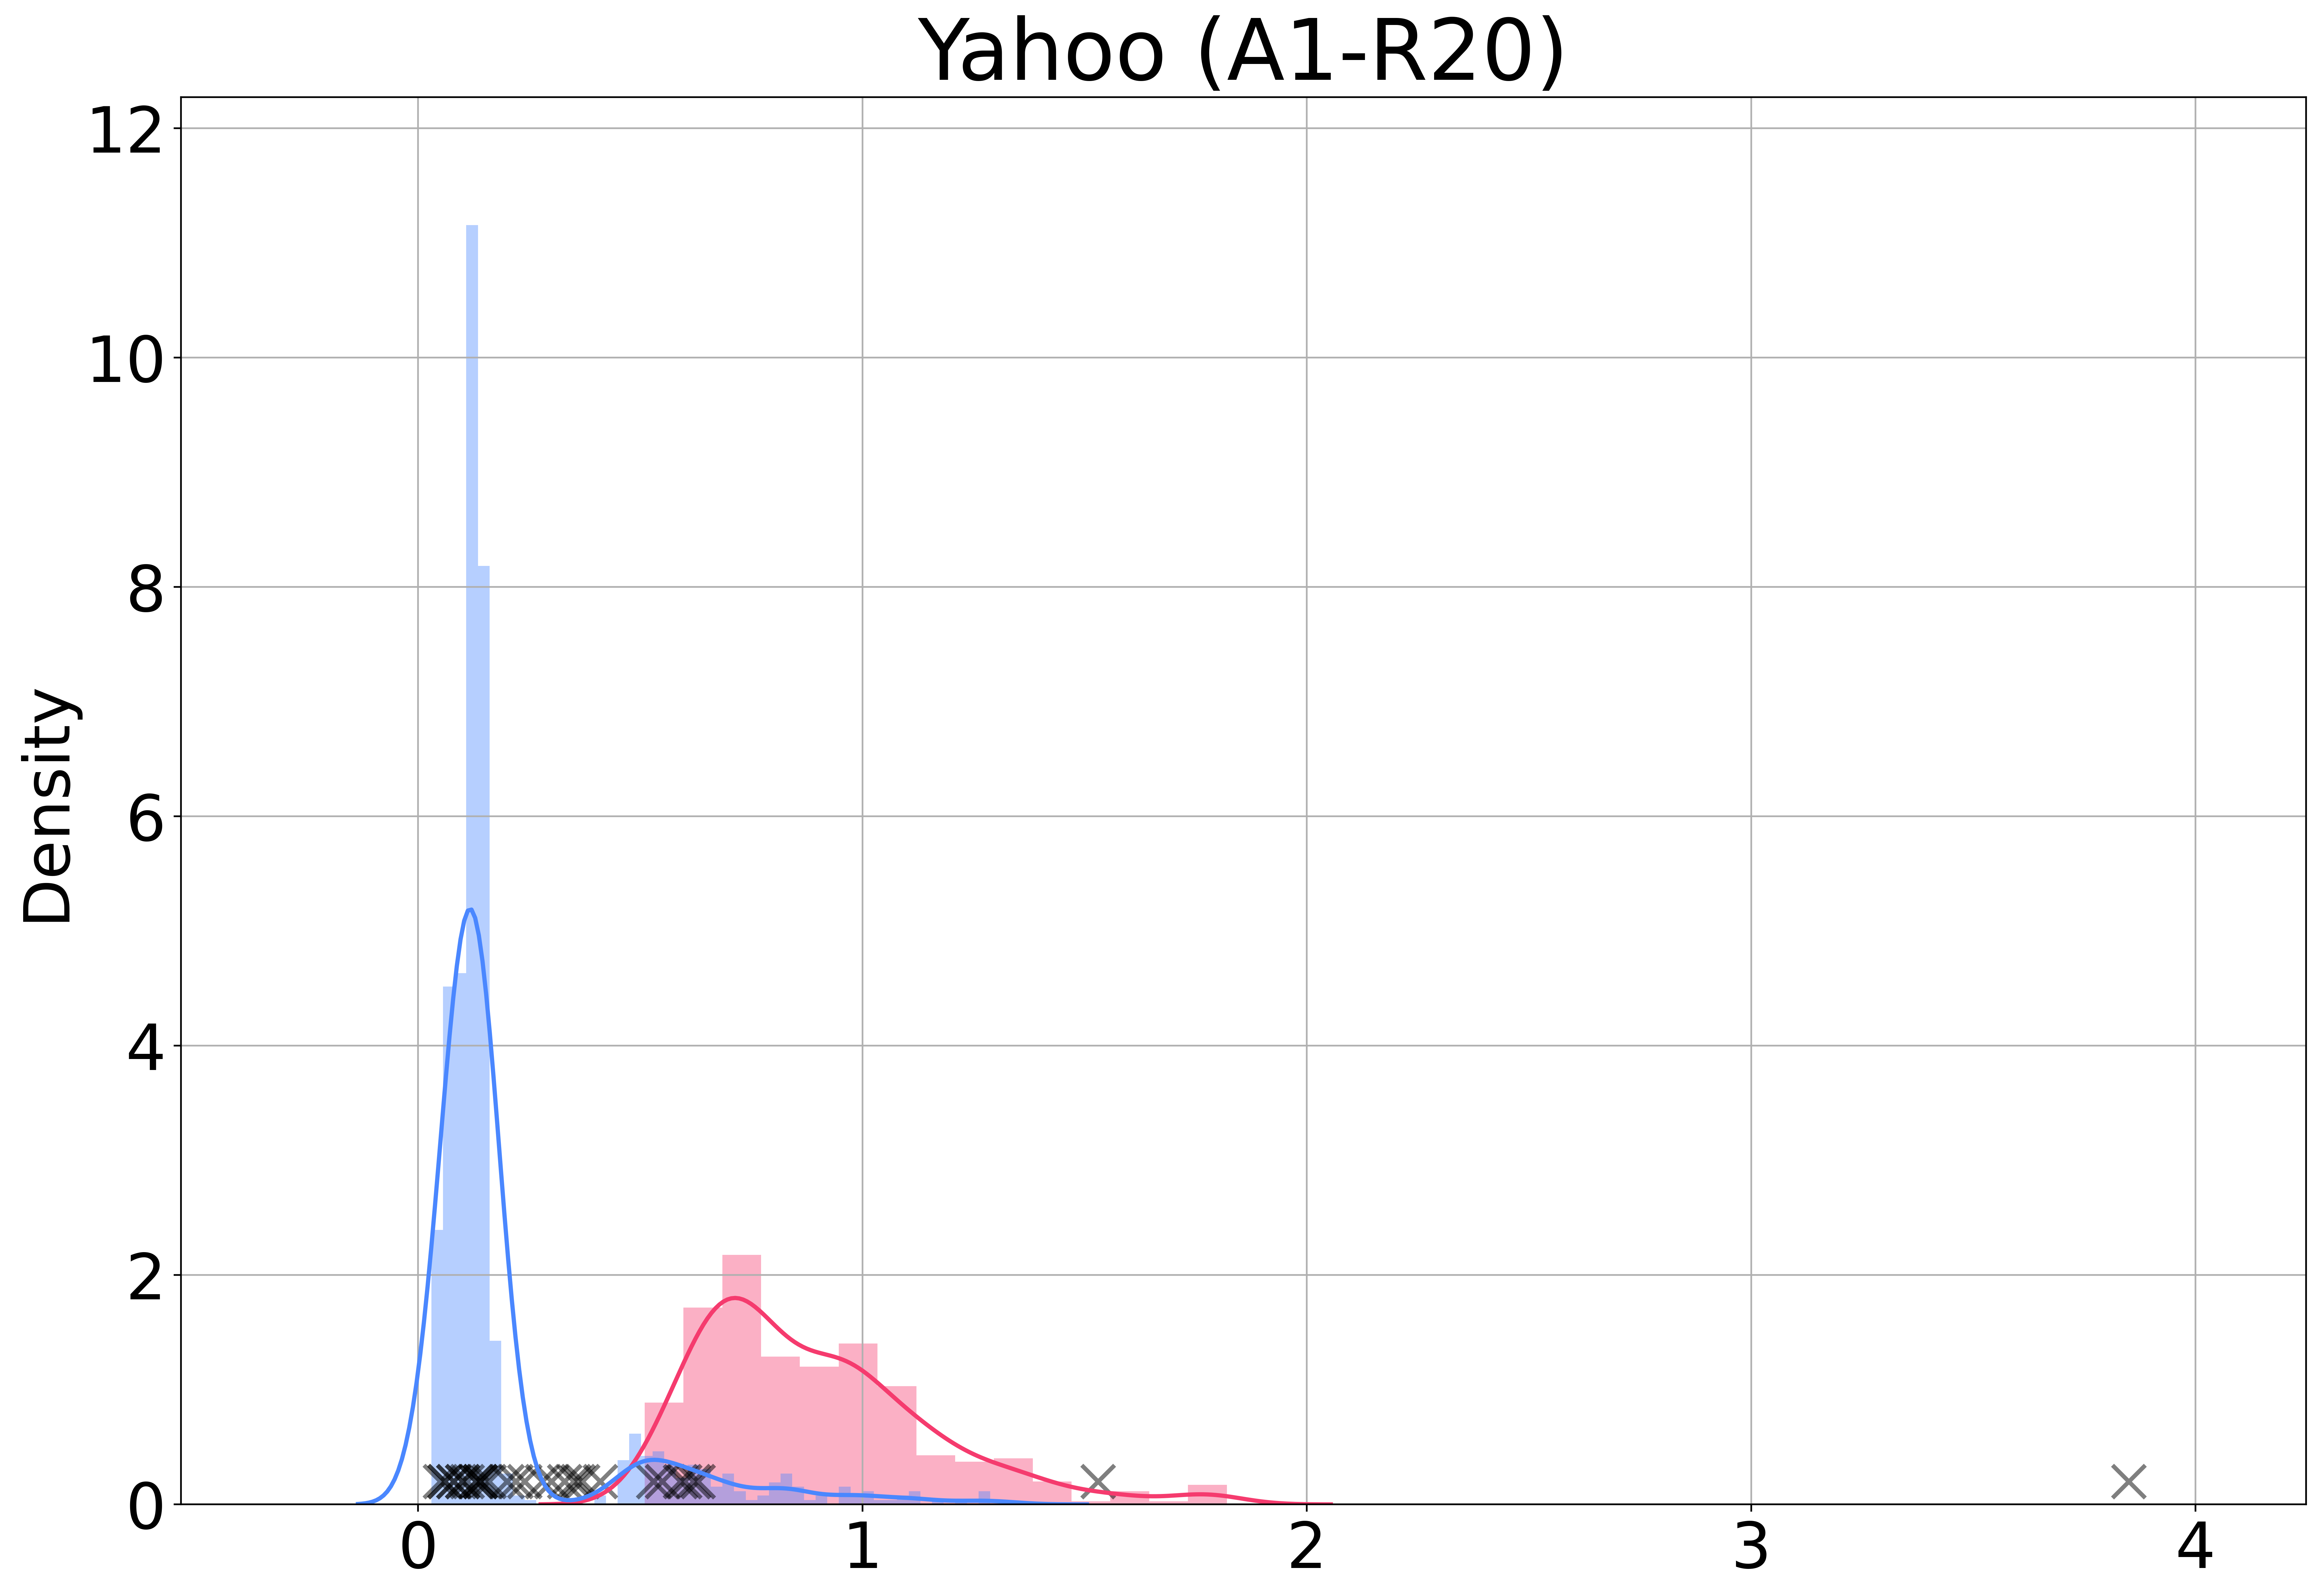

In [13]:
c = 0
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("real_20")

mask = (1-test_y).astype(bool)
test_X_anos = test_X[~mask]
test_X = test_X[mask]

plt.figure(figsize=(18, 12), dpi=500)
plt.title("Yahoo (A1-R20)", fontsize=40)
sns.distplot(train_X[:, c], color="#F53B6E")
sns.distplot(test_X[:, c], color="#4A87FF")
plt.scatter(test_X_anos, np.zeros(len(test_X_anos))+0.2, marker="x", s=240, color="black", alpha=0.5)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.savefig(f"./figures/main_figure/Yahoo_real20_tsne.pdf", dpi=300, bbox_inches = "tight")
    
plt.show()

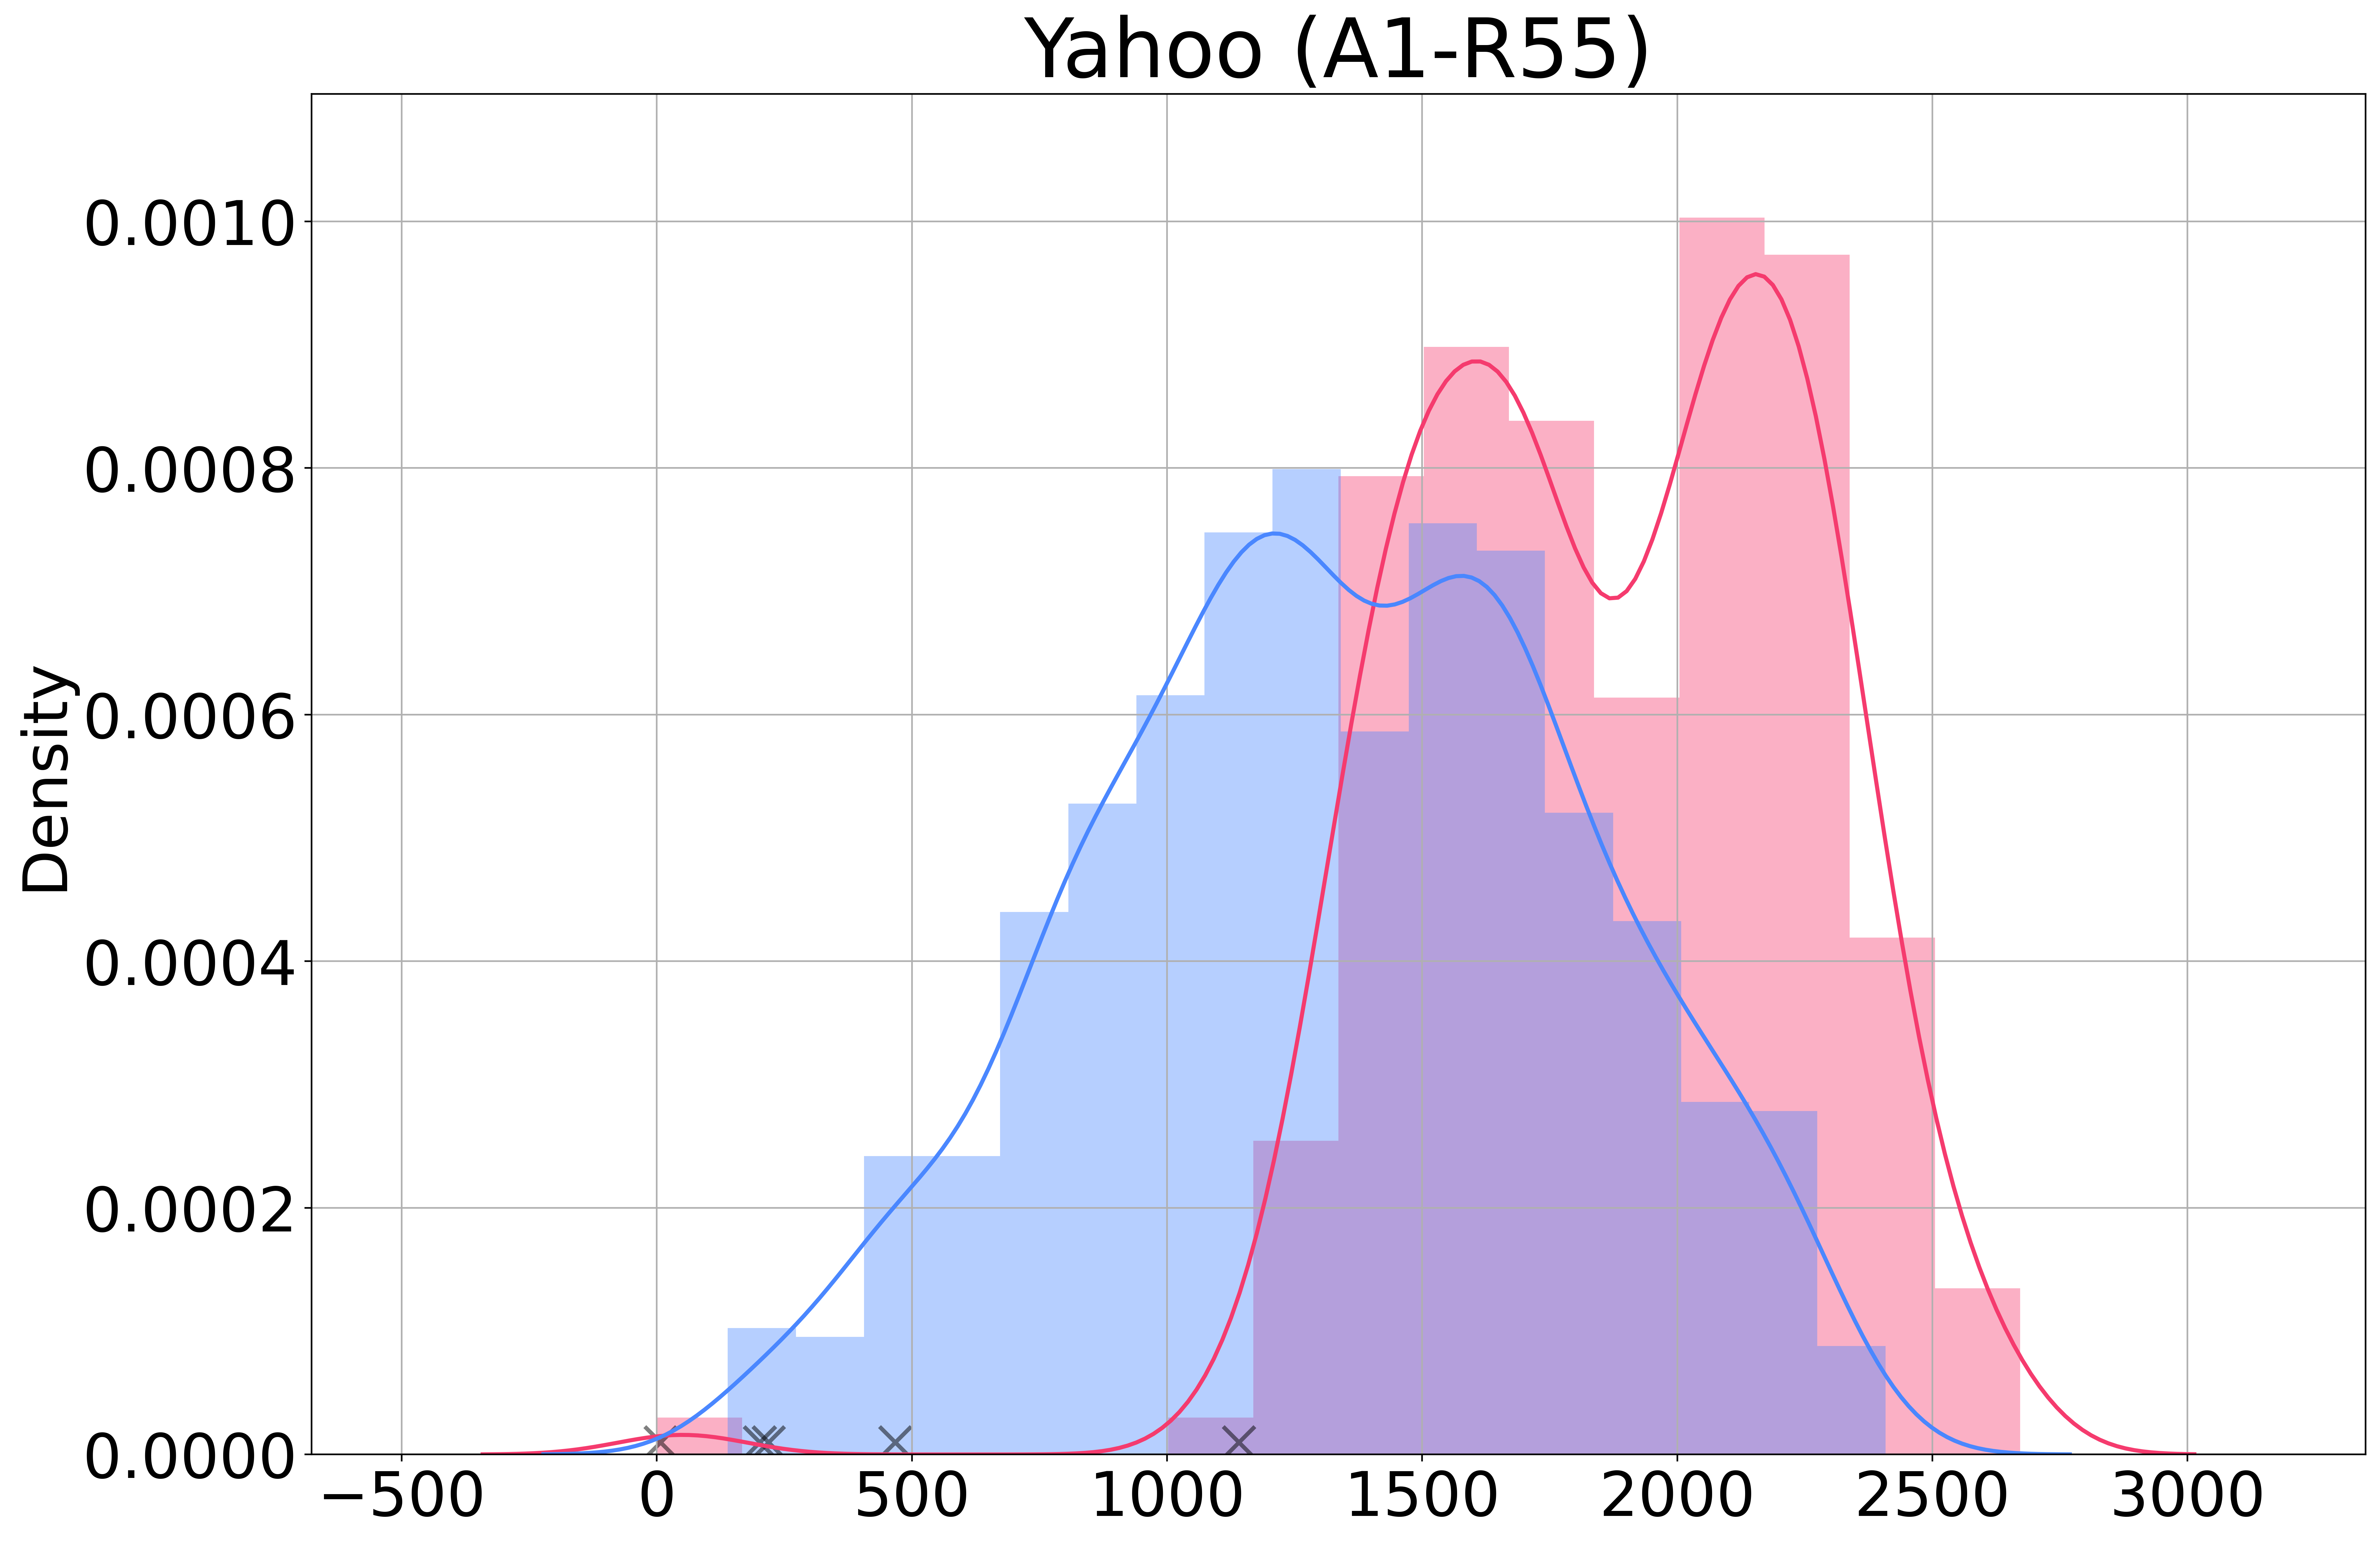

In [14]:
c = 0
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("real_55")

mask = (1-test_y).astype(bool)
test_X_anos = test_X[~mask]
test_X = test_X[mask]

plt.figure(figsize=(18, 12), dpi=500)
plt.title("Yahoo (A1-R55)", fontsize=40)
sns.distplot(train_X[:, c], color="#F53B6E")
sns.distplot(test_X[:, c], color="#4A87FF")
plt.scatter(test_X_anos, np.zeros(len(test_X_anos))+0.00001, marker="x", s=240, color="black", alpha=0.5)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.savefig(f"./figures/main_figure/Yahoo_real55_tsne.pdf", dpi=300, bbox_inches = "tight")
        
plt.show()